In [ ]:
# Import dependencies
!pip install torchdiffeq
import argparse
import time
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim


# Adjoint method is not necessary for
adjoint = False
if adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
# Print whether CPU or GPU is used.
#device = torch.device("cuda:0")


In [ ]:
# Set parameters
viz = True
test_freq = 100
save_data = False
save_freq = 10
method = 'rk4'
batch_time = 20 # time series data interval (20 time step worth of data) for a single batch
data_size = 100 # total number of data
data_size_test = 1000 # total number of data for testing
batch_size = 5 # number of batches to pick from. size should be
niters = 1000 # number of iterations.

# Generate ground truth and batch function.
true_y0 = torch.tensor([[2., 0.]]).to(device)
t = torch.linspace(0., 10., data_size).to(device)

true_y0_test = torch.tensor([[0., 2.]]).to(device)
t_test = torch.linspace(0., 10., data_size).to(device)

class Lambda(nn.Module):

    def forward(self, t, y):
        m, c, k = 1, 1, 10
        coeffMatrix = torch.tensor([[0,-k/m],[1,-c/m]]).to(device)
        # first column displacement, second column velocity
        return torch.mm(y,coeffMatrix)


with torch.no_grad(): # disable gradient calculation for true values output
    true_y = odeint(Lambda(), true_y0, t, method=method)
    true_y_test = odeint(Lambda(), true_y0_test, t_test, method=method)
print(true_y.shape)

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0.to(device), batch_t.to(device), batch_y.to(device)

# Visualize the true and predcited y

def visualize(true_y, pred_y, t, odefunc, itr):

    if viz:
        import matplotlib
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_traj2 = fig.add_subplot(132, frameon=False)
        ax_phase = fig.add_subplot(133, frameon=False)
        ax_traj.cla()
        ax_traj.set_title('Trajectories: displacement')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x')
        ax_traj.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 0], 'g-')
        ax_traj.plot(t.cpu().numpy(), pred_y.detach().cpu().numpy()[:, 0, 0], 'b--')
        ax_traj.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj.set_ylim(-3, 3)
        #ax_traj.legend()

        ax_traj2.cla()
        ax_traj2.set_title('Trajectories: velocity')
        ax_traj2.set_xlabel('t')
        ax_traj2.set_ylabel('v')
        ax_traj2.plot(t.cpu().numpy(), true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_traj2.plot(t.cpu().numpy(), pred_y.detach().cpu().numpy()[:, 0, 1], 'b--')
        ax_traj2.set_xlim(t.cpu().min(), t.cpu().max())
        ax_traj2.set_ylim(-10, 10)
        #ax_traj2.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('v')
        ax_phase.plot(true_y.cpu().numpy()[:, 0, 0], true_y.cpu().numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.detach().cpu().numpy()[:, 0, 0], pred_y.detach().cpu().numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(-3, 3)
        ax_phase.set_ylim(-10, 10)

        fig.tight_layout()
        #plt.savefig('png/{:03d}'.format(itr))
        plt.show(block=False)

# Create and save data module
def savedata(true_y, pred_y, t, odefunc, itr, append_name):

    if save_data:

        f_true_y = './data/true_'+str(itr)+'_'+append_name+'.txt'
        f_pred_y = './data/pred_'+str(itr)+'_'+append_name+'.txt'
        f_t = './data/t_'+str(itr)+'_'+append_name+'.txt'
        np.savetxt(f_true_y, np.squeeze(true_y.detach().cpu().numpy()), delimiter=",")
        np.savetxt(f_pred_y, np.squeeze(pred_y.detach().cpu().numpy()), delimiter=",")
        np.savetxt(f_t, np.squeeze(t.detach().cpu().numpy()), delimiter=",")


torch.Size([100, 1, 2])


In [ ]:

# Building NN ODE

class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Softplus(),
            nn.Linear(20, 1),
        )

        self.register_buffer('coeffMatrix1',torch.tensor([[0,0],[1,-1/1]]).float())
        self.register_buffer('coeffMatrix2',torch.tensor([[0,-1/1],[0,0]]).float())

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        # print("doing forward pass")
        yp = y[...,0:1]
        yp.requires_grad_(True) # defines that the gradient is needed to be calculated for the yp
        # print(y.shape)
        # print(y[:,:,0:1].shape)
        out = self.net(yp) + self.net(-yp)
        # print(out.shape)
        deriv = torch.autograd.grad([out.sum()],[yp],retain_graph=True,create_graph=True)
        grad = deriv[0]
        if grad is not None:
            return torch.matmul(y,self.coeffMatrix1) + torch.matmul(torch.cat((grad,torch.zeros_like(grad)),-1),self.coeffMatrix2)

Iter 0100 | Training total Loss 1.225138


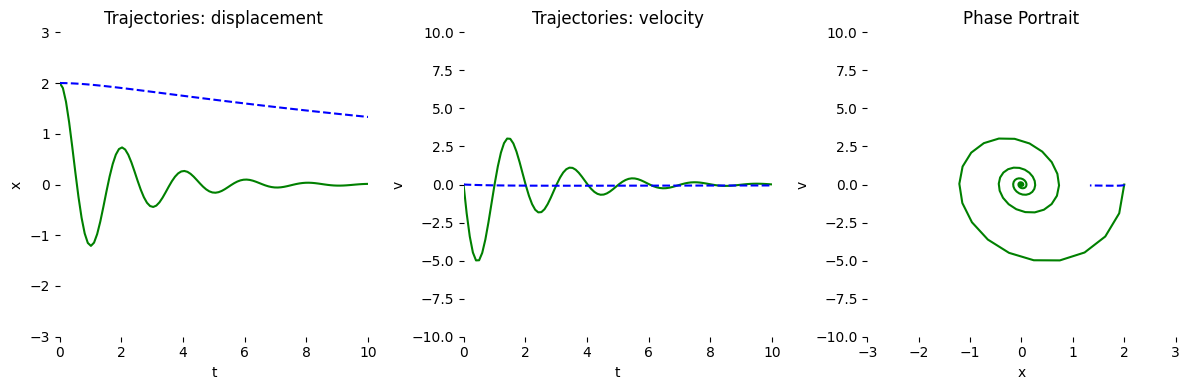

Iter 0100 | Test total Loss 0.907271


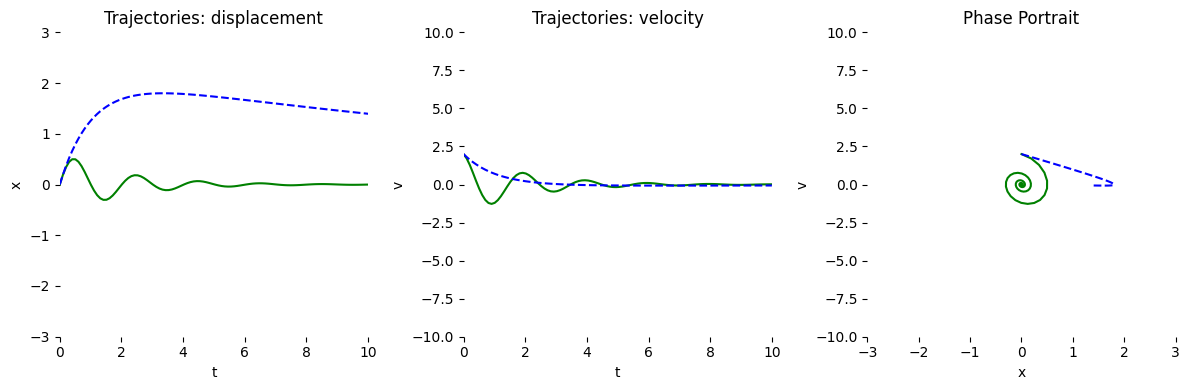

Iter 0200 | Training total Loss 0.738175


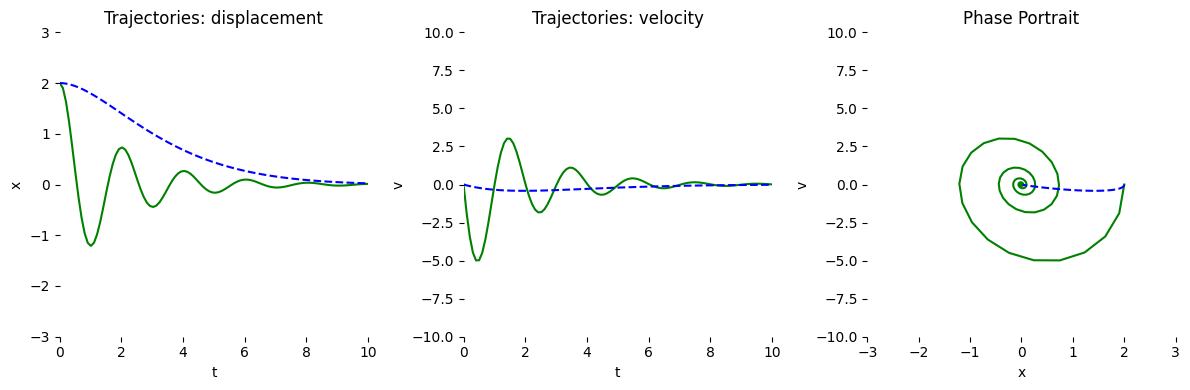

Iter 0200 | Test total Loss 0.500876


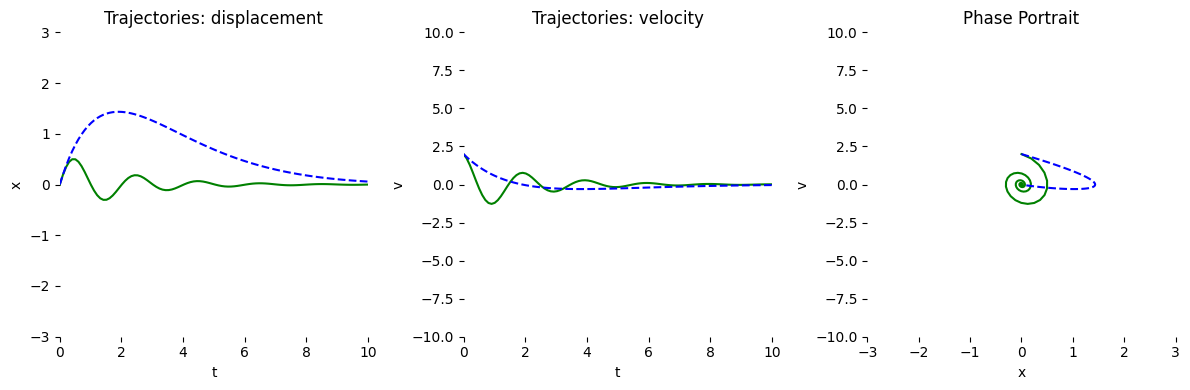

Iter 0300 | Training total Loss 0.584677


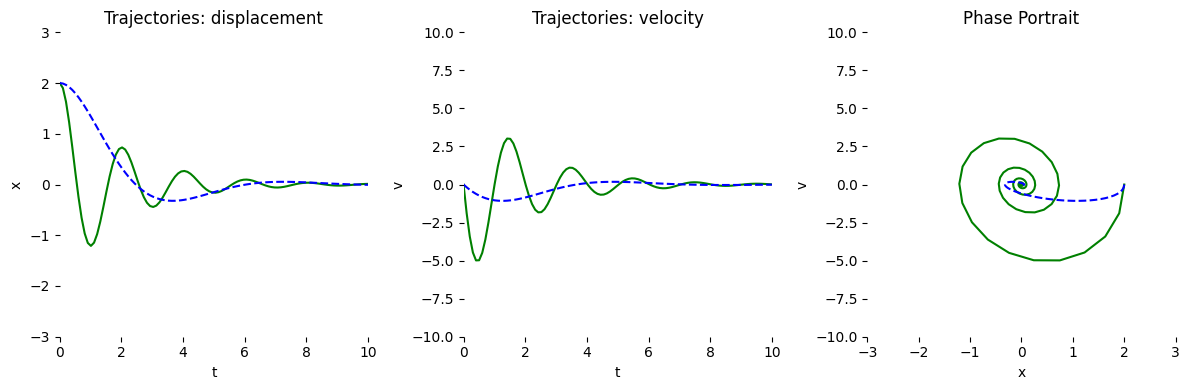

Iter 0300 | Test total Loss 0.291266


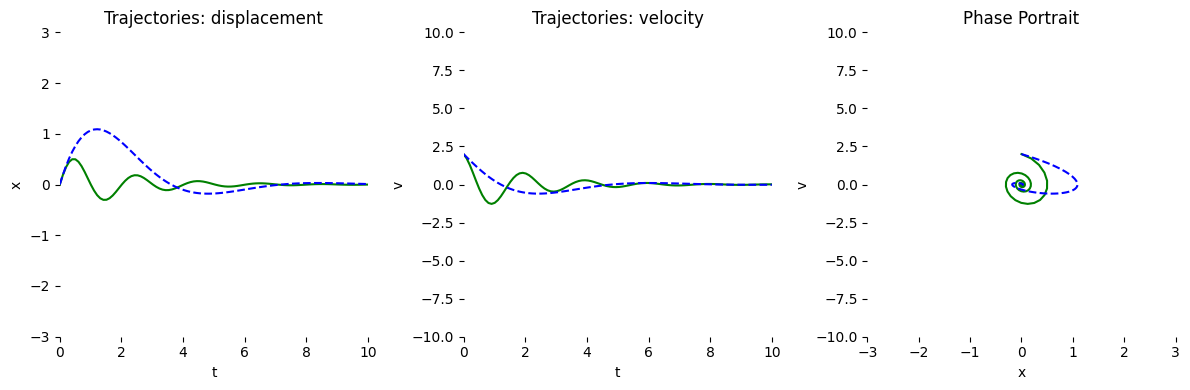

Iter 0400 | Training total Loss 0.580406


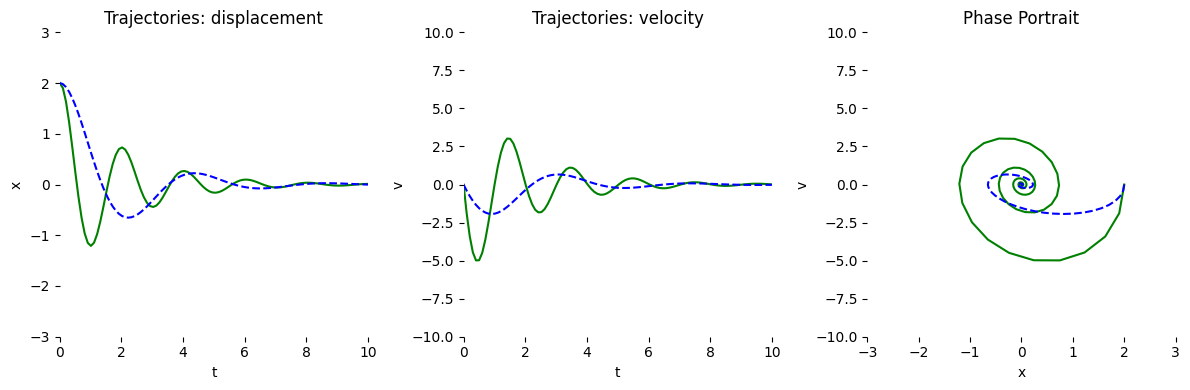

Iter 0400 | Test total Loss 0.232902


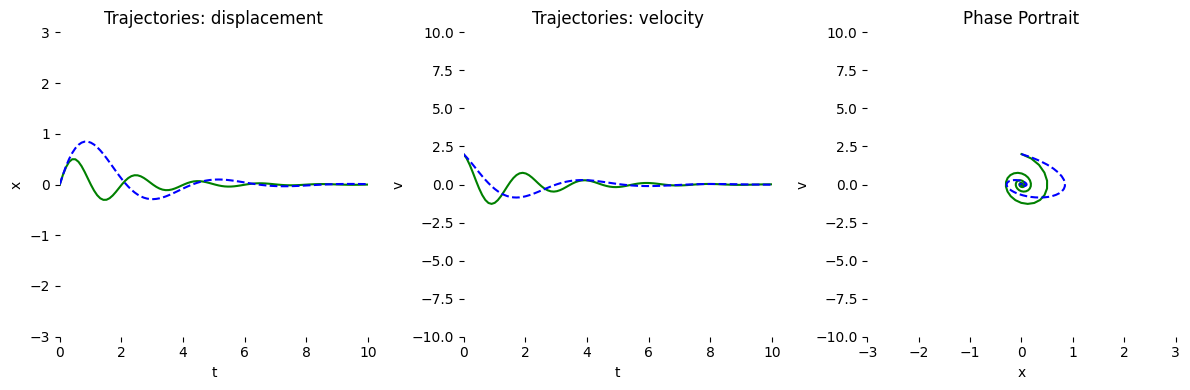

Iter 0500 | Training total Loss 0.566254


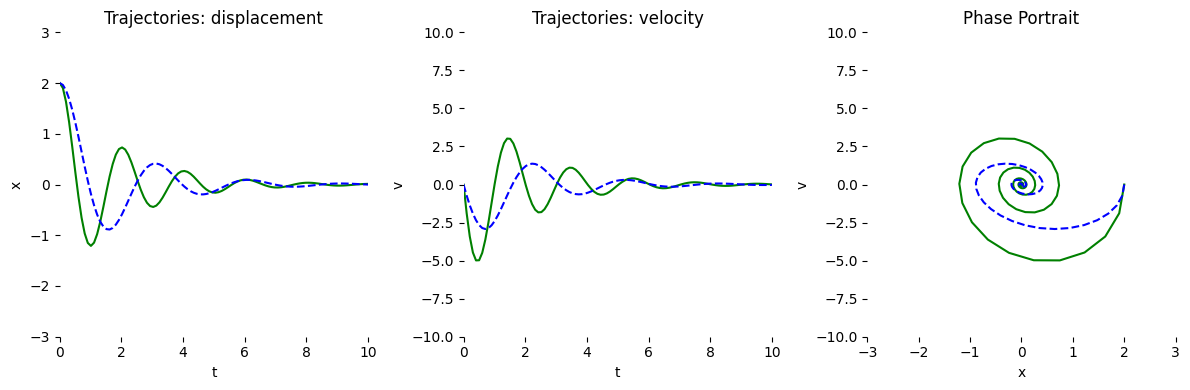

Iter 0500 | Test total Loss 0.194988


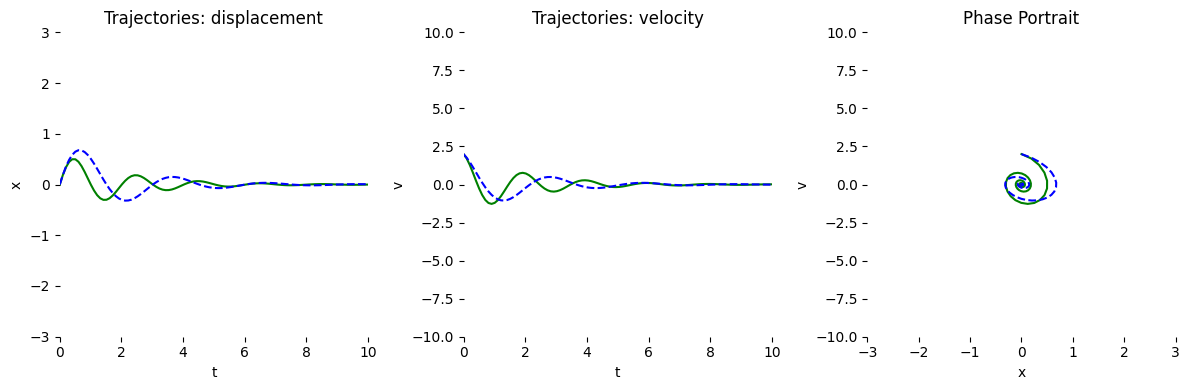

Iter 0600 | Training total Loss 0.425261


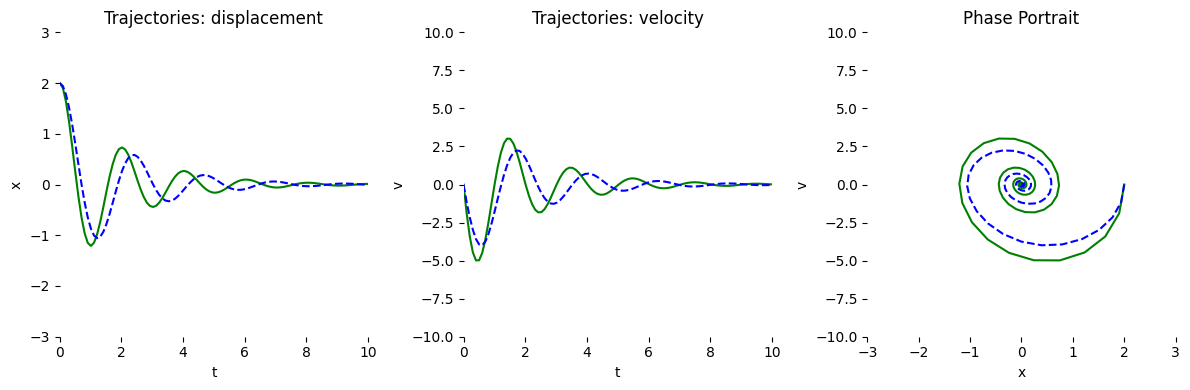

Iter 0600 | Test total Loss 0.108731


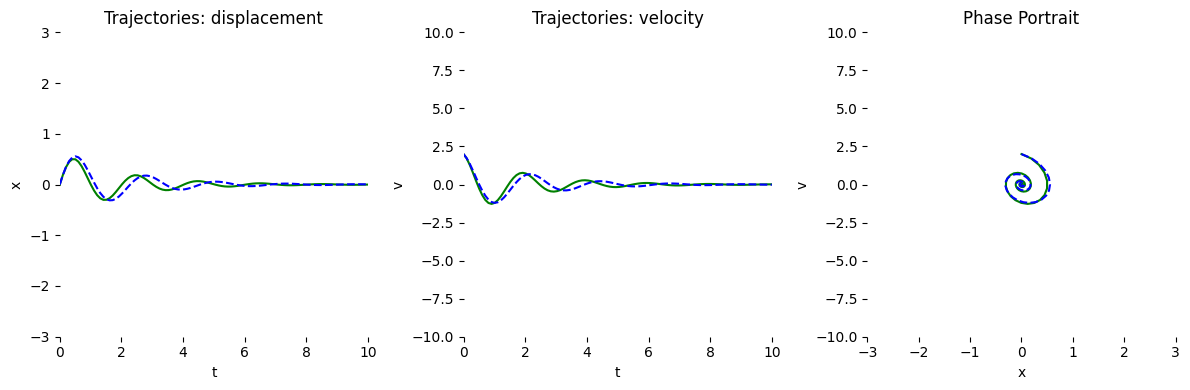

Iter 0700 | Training total Loss 0.097355


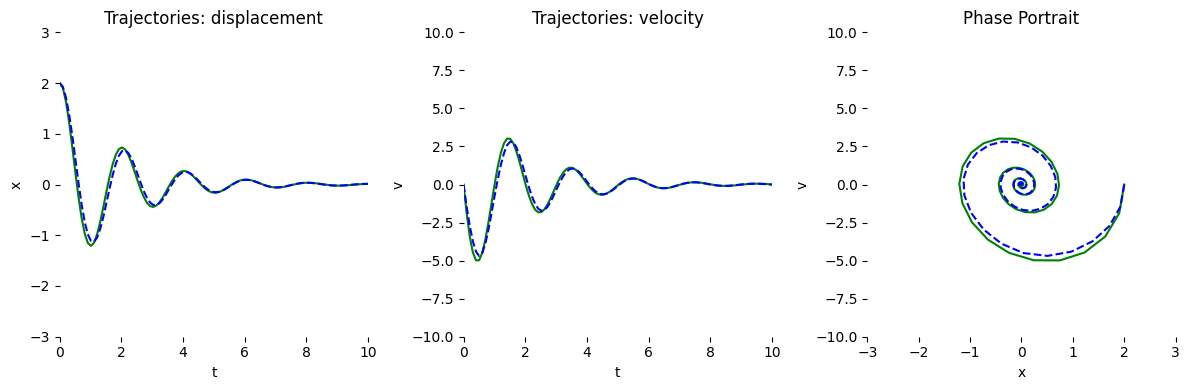

Iter 0700 | Test total Loss 0.018182


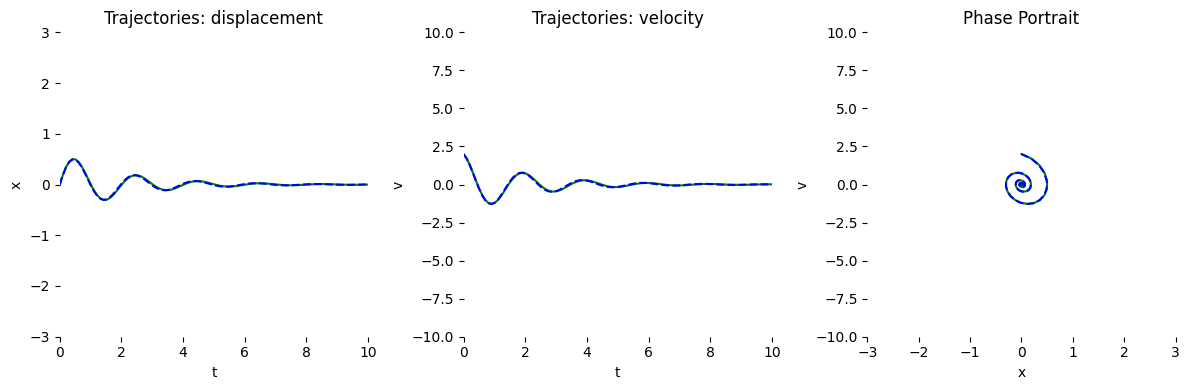

Iter 0800 | Training total Loss 0.100708


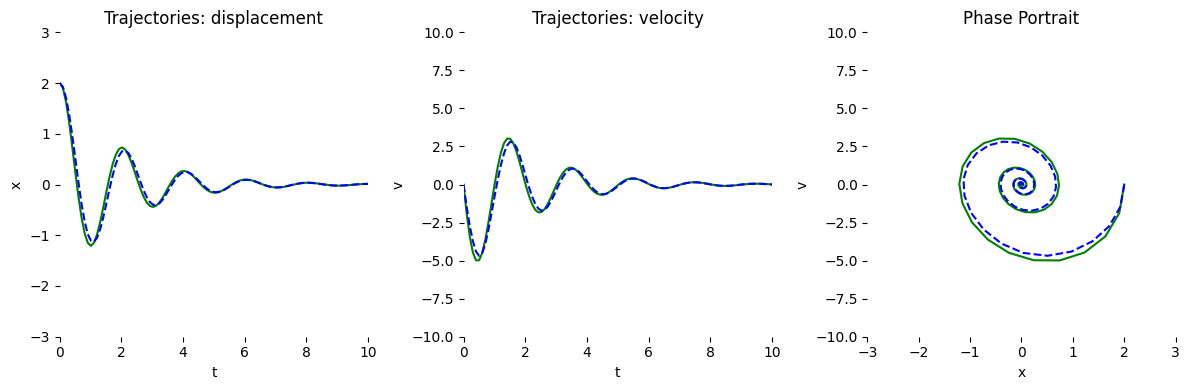

Iter 0800 | Test total Loss 0.016167


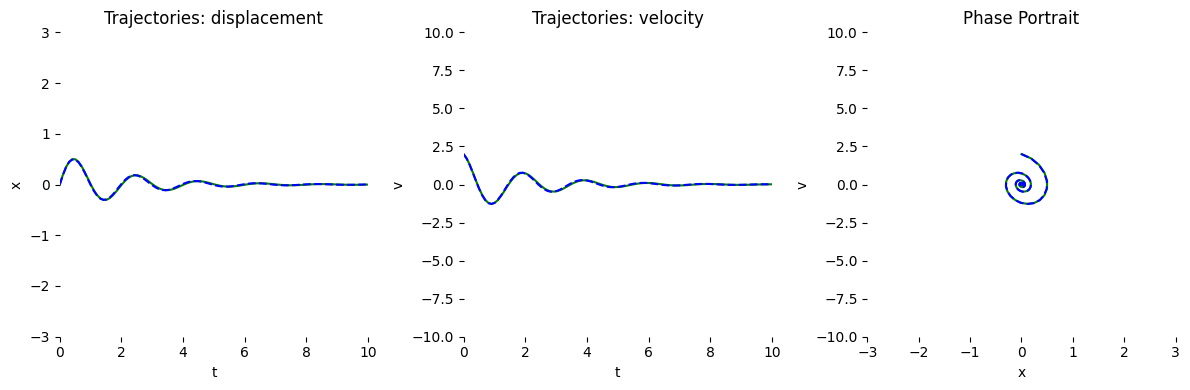

Iter 0900 | Training total Loss 0.110577


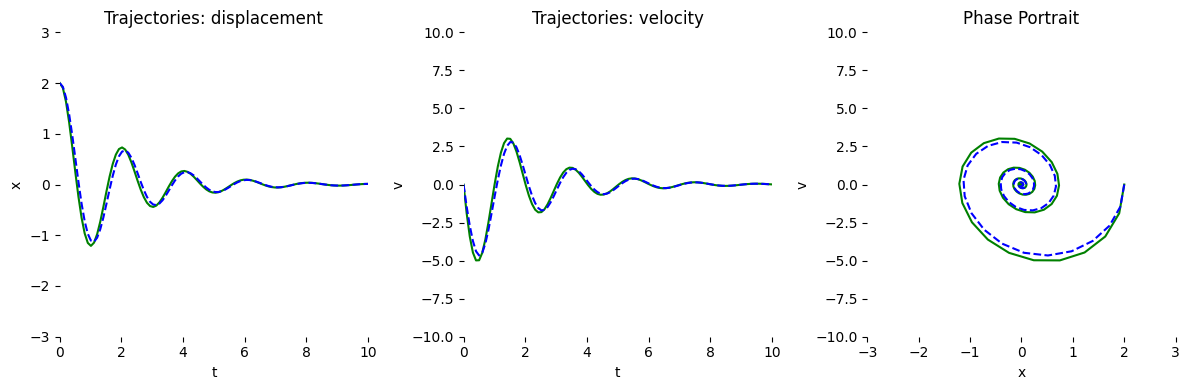

Iter 0900 | Test total Loss 0.011768


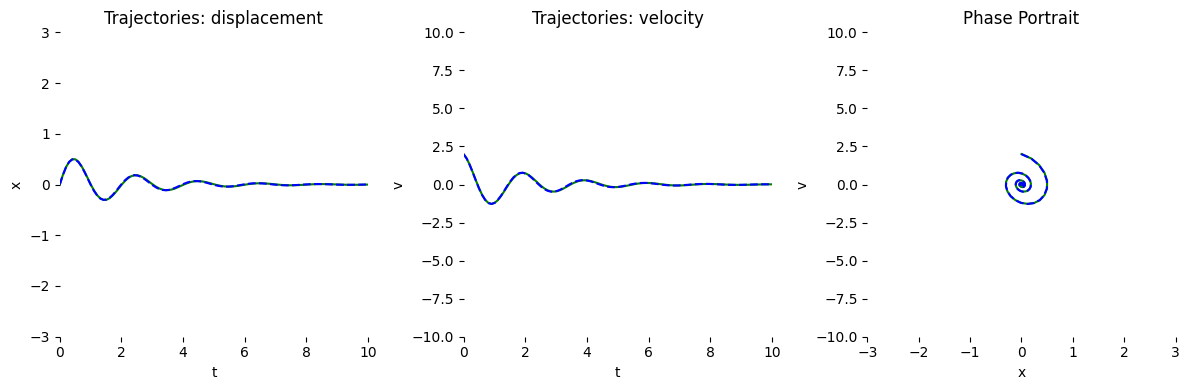

Iter 1000 | Training total Loss 0.097585


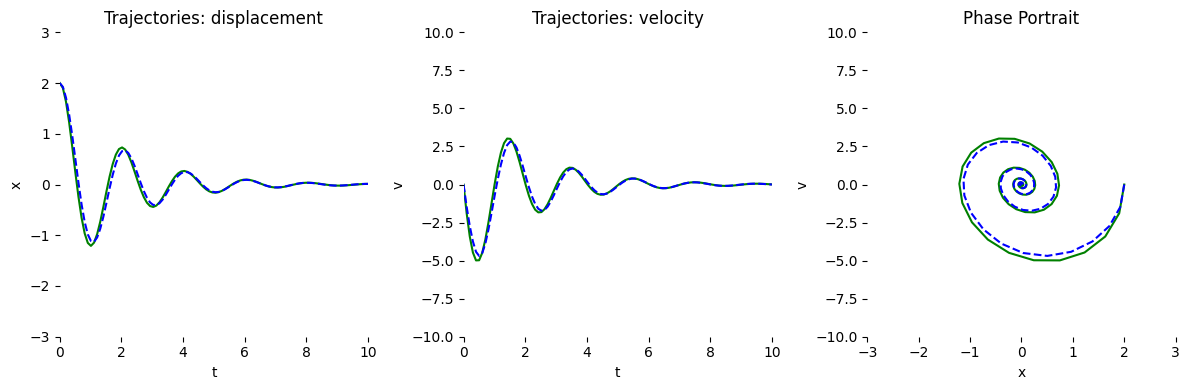

Iter 1000 | Test total Loss 0.016793


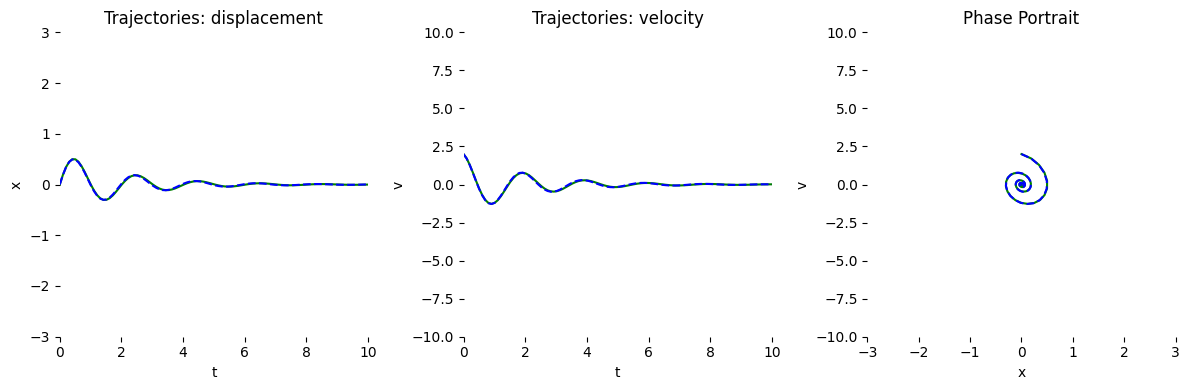

In [ ]:
# Main function
if __name__ == '__main__':

    ii = 0

    func = ODEFunc().to(device) # transform the tensor fitted to device either CPU and GPU

    # optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
    optimizer = optim.Adam(func.parameters(), lr=1e-3)
    end = time.time()

    for itr in range(1, niters + 1):
        # print(str(itr) + ": before the iteration")
        optimizer.zero_grad() # initialize
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t).to(device)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        # print(str(itr) + "after backward")

        if itr % test_freq == 0:

            # with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Training total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, t, func, ii)

            pred_y_test = odeint(func, true_y0_test, t_test)
            loss = torch.mean(torch.abs(pred_y_test - true_y_test))
            print('Iter {:04d} | Test total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y_test, pred_y_test, t_test, func, ii)
            ii += 1

        if itr % save_freq == 0:
            pred_y = odeint(func, true_y0, t)
            pred_y_test = odeint(func, true_y0_test, t_test)
            savedata(true_y, pred_y, t, func, itr, 'train')
            savedata(true_y_test, pred_y_test, t_test, func, itr, 'test')


        # print(str(itr) + "after test")
        end = time.time()

    traced_script_module = torch.jit.script(func.to("cpu"))
    traced_script_module = traced_script_module.to("cpu")
    traced_script_module.save("./traced_massspring.pt") # saves the trained module to run the trained NN ODE
    func.to(device)

In [ ]:
modelex = torch.jit.load("/content/traced_massspring.pt")

In [ ]:
modelex.state_dict()
# Examples to view the trained NN parameteres
# mode.state_dict()['net.0.weight'].data

OrderedDict([('coeffMatrix1',
              tensor([[ 0.,  0.],
                      [ 1., -1.]])),
             ('coeffMatrix2',
              tensor([[ 0., -1.],
                      [ 0.,  0.]])),
             ('net.0.weight',
              tensor([[-1.0542e+00],
                      [ 1.0921e+00],
                      [ 1.0529e+00],
                      [-1.0706e+00],
                      [ 1.0767e+00],
                      [ 1.0870e+00],
                      [ 1.1149e+00],
                      [ 1.0598e+00],
                      [-1.0930e+00],
                      [-3.5247e-04],
                      [ 2.7747e-08],
                      [ 1.0821e+00],
                      [ 1.0718e+00],
                      [ 6.9181e-08],
                      [ 1.1142e+00],
                      [ 1.0854e+00],
                      [ 1.1001e+00],
                      [-1.0805e+00],
                      [-1.1161e+00],
                      [ 2.2163e-09]])),
             ('net.0.bias

In [ ]:
modelex.parameters

<bound method Module.parameters of RecursiveScriptModule(
  original_name=ODEFunc
  (net): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Linear)
    (1): RecursiveScriptModule(original_name=Softplus)
    (2): RecursiveScriptModule(original_name=Linear)
  )
)>